In [1]:
# Now lets load the model and perform our predictions
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from imutils import paths


Using TensorFlow backend.


In [2]:
model = load_model('model.h5')

W0927 21:35:44.978629  6072 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 21:35:45.006554  6072 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 21:35:45.066393  6072 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 21:35:45.067420  6072 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Pleas

In [5]:
import project_configuration as conf
# Preprocess test data and predict
all_testing_paths = list(paths.list_images(conf.TEST_PATH))
total_testing_examples = len(all_testing_paths)
print('Total testing paths :',total_testing_examples)

Total testing paths : 55505


In [7]:
test_data_aug = ImageDataGenerator(rescale=1/255.0)
test_generator = test_data_aug.flow_from_directory(
                                    directory = conf.TEST_PATH,
                                    class_mode = 'categorical',
                                    target_size = (48,48),
                                    color_mode = 'rgb',
                                    shuffle = False,
                                    batch_size = 32 )
test_generator.reset()

Found 55505 images belonging to 2 classes.


In [10]:
import numpy as np
predicted_ids = model.predict_generator(generator=test_generator,
                                        steps=(int(total_testing_examples/ 32) + 1 ) )

In [11]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predicted_ids = np.argmax(predicted_ids ,axis =1)

In [12]:
from sklearn.metrics import classification_report,confusion_matrix 

print(classification_report(test_generator.classes,predicted_ids,target_names=test_generator.class_indices.keys()))


              precision    recall  f1-score   support

           0       0.94      0.89      0.91     39769
           1       0.76      0.84      0.80     15736

   micro avg       0.88      0.88      0.88     55505
   macro avg       0.85      0.87      0.86     55505
weighted avg       0.89      0.88      0.88     55505



In [13]:
cm = confusion_matrix(test_generator.classes,predicted_ids)
print(cm)

[[35563  4206]
 [ 2469 13267]]


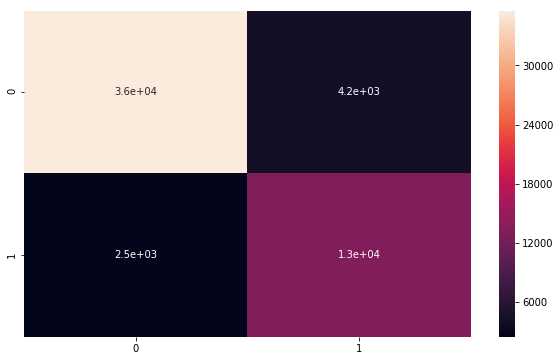

In [20]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
cm_df = pd.DataFrame(cm,columns=['0','1'],index=['0','1'])
plt.figure(figsize=(10,6))
sns.heatmap(cm_df,annot=True)

In [27]:
total = sum(sum(cm))
accuracy = (cm[0,0]+cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])

print("accuracy: {:.4f} %".format(accuracy*100))
print("sensitivity: {:.4f} %".format(sensitivity*100))
print("specificity: {:.4f} %".format(specificity*100))

accuracy: 87.9741 %
sensitivity: 89.4239 %
specificity: 84.3099 %


The model has acheived around 88 % Accuracy.
But the model has predicted '0' -  No cancer because of the imbalance in training data.

Our sensitivity measures the proportion of the true positives that were also predicted as positive (89.4239 %).

Conversely, specificity measures our true negatives (84.3099 %).

We need to be really careful with our false negative here — we don’t want to classify someone as “No cancer” when they are in fact “Cancer positive”.

Our false positive rate is also important — we don’t want to mistakenly classify someone as “Cancer positive” and then subject them to painful, expensive, and invasive treatments when they don’t actually need them.